In [1]:
# importing libararies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sqlalchemy import create_engine

# Define server and database name
server = r"UZZII\SQLEXPRESS"
database = "E_COMMERCE"

# Create engine using Windows Authentication
engine = create_engine(
    f"mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
)

In [3]:
# loading data

orders = pd.read_sql('select * from orders',engine)
order_item_refunds = pd.read_sql('select * from order_item_refunds',engine)
order_items = pd.read_sql('select * from order_items',engine)
products = pd.read_sql('select * from products',engine)
website_pageviews = pd.read_sql('select * from website_pageviews',engine)
w_sessions = pd.read_sql('select * from w_sessions',engine)

## EDA

In [ ]:
orders.shape

In [ ]:
order_item_refunds.shape

In [ ]:
order_items.shape

In [ ]:
products.shape

In [ ]:
website_pageviews.shape

In [ ]:
w_sessions.shape

In [ ]:
orders.head(5)

In [ ]:
order_item_refunds.head(5)

In [ ]:
order_items.head(2)

In [ ]:
products.head()

In [ ]:
website_pageviews.head(5)

In [ ]:
w_sessions.head(5)

In [ ]:
order_item_refunds.info()

In [ ]:
order_items.info()

In [ ]:
products.info()

In [ ]:
orders.info()

In [ ]:
orders['cogs_usd'].unique()[:10]

In [ ]:
#Changing data type of cogs_used from object to float64

def time_to_hhmm(t):
    if pd.isnull(t):
        return np.nan
    return float(f"{t.hour:02d}.{t.minute:02d}")

orders['cogs_float'] = orders['cogs_usd'].apply(time_to_hhmm)


In [ ]:
orders[['cogs_float', 'cogs_usd']].head()
orders['cogs_float'].dtype  # should be float64


In [ ]:
orders.info()

In [ ]:
orders.drop('cogs_usd', axis=1, inplace=True)

In [ ]:
orders.info()

In [ ]:
orders.rename(columns={'cogs_float':'cogs_usd'},inplace=True)

In [ ]:
orders.info()

In [ ]:
w_sessions.info()

# TRAFFIC SOURCE ANALYSIS


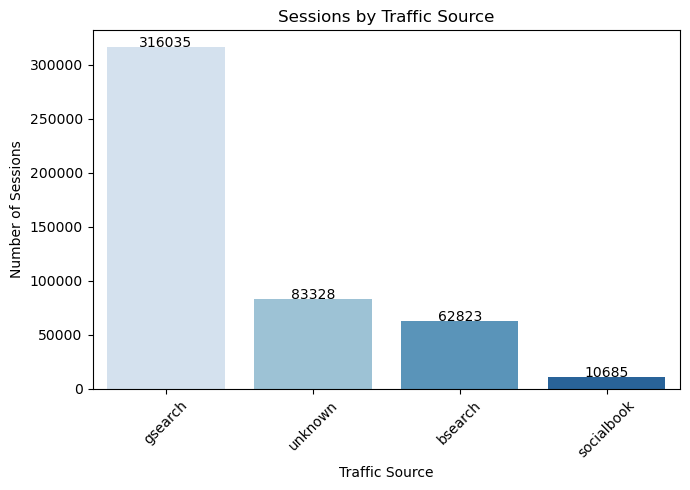

In [4]:
#1. Count of Sessions by Traffic Source

source_counts = w_sessions['utm_source'].value_counts().reset_index()
source_counts.columns = ['utm_source', 'session_count']

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=source_counts, x='utm_source', y='session_count', palette='Blues')
#ADDING DATA labels
for index, row in source_counts.iterrows():
    plt.text(index, row['session_count'], row['session_count'], color='black', ha="center")
plt.title('Sessions by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


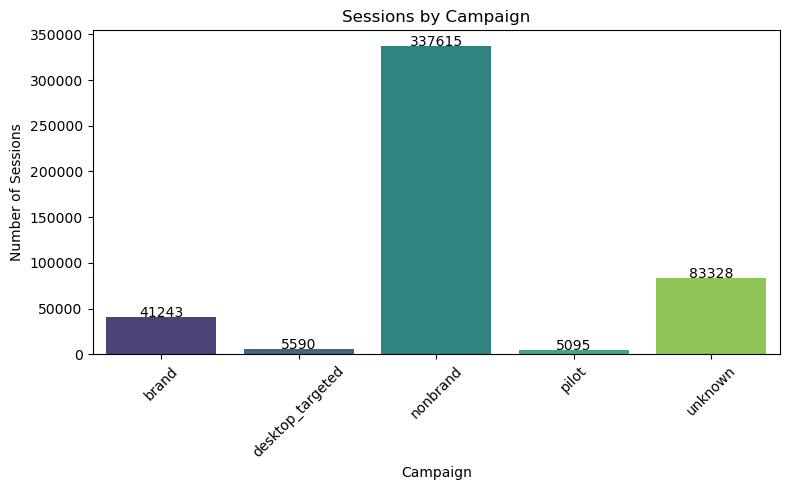

In [5]:
#2. Sessions by Campaign

source_campaign = w_sessions.groupby(['utm_campaign']).agg({
    'website_session_id': 'count'
}).reset_index().rename(columns={'website_session_id': 'sessions'})

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=source_campaign, x='utm_campaign', y='sessions', palette='viridis')
#ADDING DATA LABELS
for index, row in source_campaign.iterrows():
    plt.text(index, row['sessions'], row['sessions'], color='black', ha="center")

plt.title('Sessions by Campaign')
plt.xlabel('Campaign')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



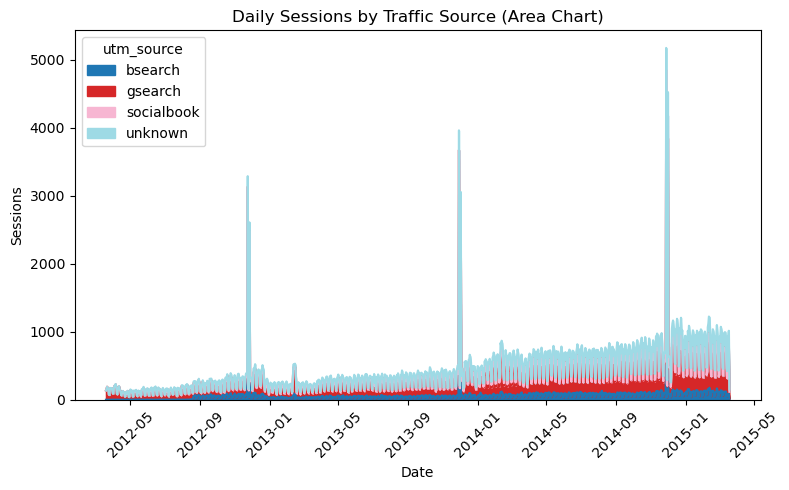

In [6]:
#DAILY SESSIONS BY TRAFFIC SOURCE


w_sessions['date'] = w_sessions['created_at'].dt.date

time_series = (
    w_sessions.groupby(['date', 'utm_source'])
    .size()
    .reset_index(name='sessions')
)


plt.figure(figsize=(8, 5))
time_series_pivot = time_series.pivot(index='date', columns='utm_source', values='sessions').fillna(0)
time_series_pivot.plot.area(ax=plt.gca(), colormap='tab20')
plt.title('Daily Sessions by Traffic Source (Area Chart)')
plt.xlabel('Date')
plt.ylabel('Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

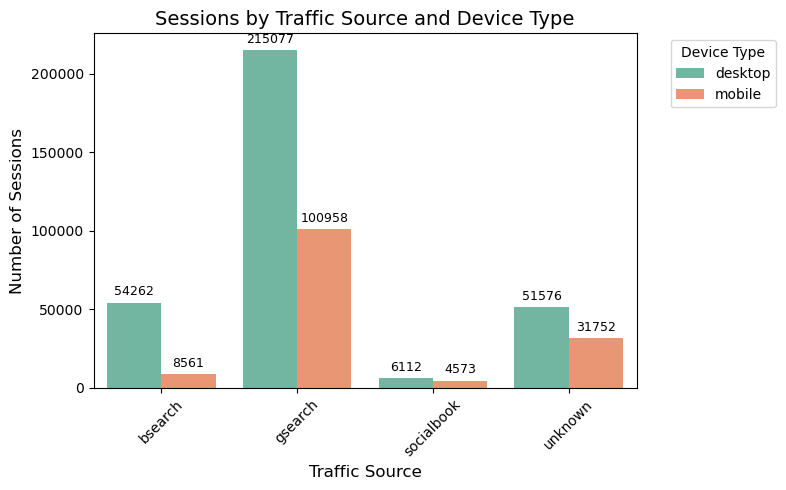

In [7]:
#Sessions by Traffic Source and Device Type

source_device = (
    w_sessions.groupby(['utm_source', 'device_type'])
    .agg(session_count=('website_session_id', 'count'))
    .reset_index()
)

# Plotting Source Breakdown by Device Type

plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(
    data=source_device, 
    x='utm_source', 
    y='session_count', 
    hue='device_type', 
    palette='Set2'
)

# Add data labels on each bar
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=3)

plt.title('Sessions by Traffic Source and Device Type', fontsize=14)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




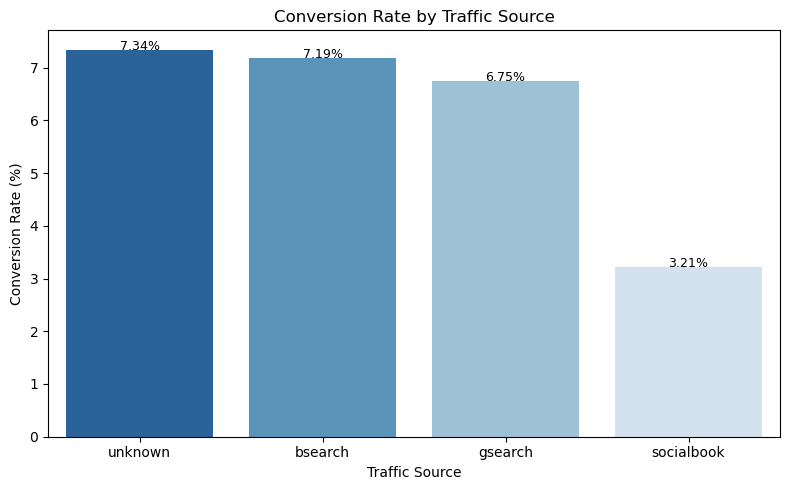

In [8]:
#Conversion Rate by Source
# STEP 1: Create converted flag in orders
orders['converted'] = 1

# STEP 2: Merge sessions with orders
sessions_merged = w_sessions.merge(orders[['website_session_id', 'converted']], on='website_session_id', how='left')

# STEP 3: Fill missing conversions
sessions_merged['converted'] = sessions_merged['converted'].fillna(0).astype(int)

# STEP 4: Group and calculate CVR
cvr_by_source = (
    sessions_merged.groupby('utm_source')
    .agg(total_sessions=('website_session_id', 'nunique'),
         orders=('converted', 'sum'))
    .reset_index()
)

cvr_by_source['conversion_rate (%)'] = (
    cvr_by_source['orders'] / cvr_by_source['total_sessions'] * 100
).round(2)

# Sort for plotting
cvr_sorted = cvr_by_source.sort_values(by='conversion_rate (%)', ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    data=cvr_sorted,
    x='utm_source',
    y='conversion_rate (%)',
    palette='Blues_r'
)

# Add data labels
for index, value in enumerate(cvr_sorted['conversion_rate (%)']):
    plt.text(index, value, f'{value}%', ha='center', fontsize=9)

plt.title('Conversion Rate by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Conversion Rate (%)')
plt.tight_layout()
plt.show()


   utm_source  total_revenue
1     gsearch   1.276145e+06
3     unknown   3.714330e+05
0     bsearch   2.686725e+05
2  socialbook   2.225933e+04


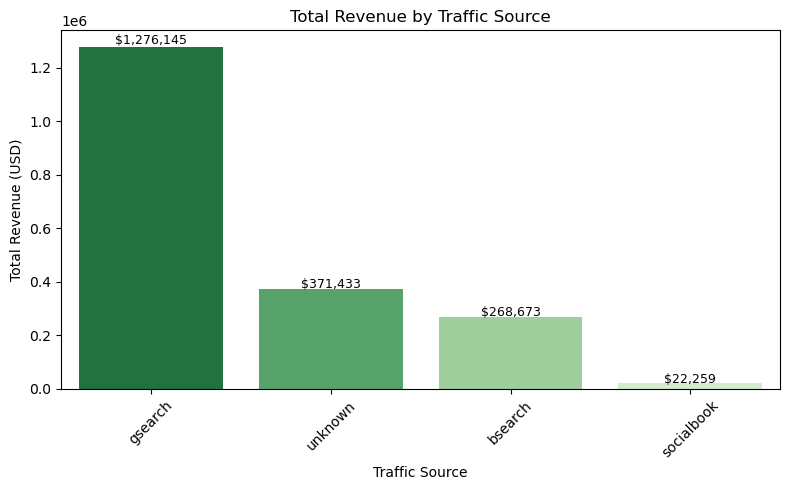

In [10]:
# Revenue by Source

# STEP 1: Merge orders with sessions to get source info for each order
orders_with_source = orders.merge(w_sessions[['website_session_id', 'utm_source']],on='website_session_id',how='left')

# STEP 2: Group by source and sum revenue
revenue_by_source = (
    orders_with_source
    .groupby('utm_source')
    .agg(total_revenue=('price_usd', 'sum'))
    .reset_index()
    .sort_values(by='total_revenue', ascending=False)
)

# Display result
print(revenue_by_source)

#Visualize Revenue by Source
plt.figure(figsize=(8, 5))
sns.barplot(
    data=revenue_by_source,
    x='utm_source',
    y='total_revenue',
    palette='Greens_r'
)

# Add data labels
for index, value in enumerate(revenue_by_source['total_revenue']):
    plt.text(index, value + (value * 0.01), f'${value:,.0f}', ha='center', fontsize=9)

plt.title('Total Revenue by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   utm_source  total_sessions  bounce_sessions  bounce_rate (%)
2  socialbook           10685             8295            77.63
0     bsearch           62823            29826            47.48
1     gsearch          316035           140273            44.39
3     unknown           83328            33246            39.90


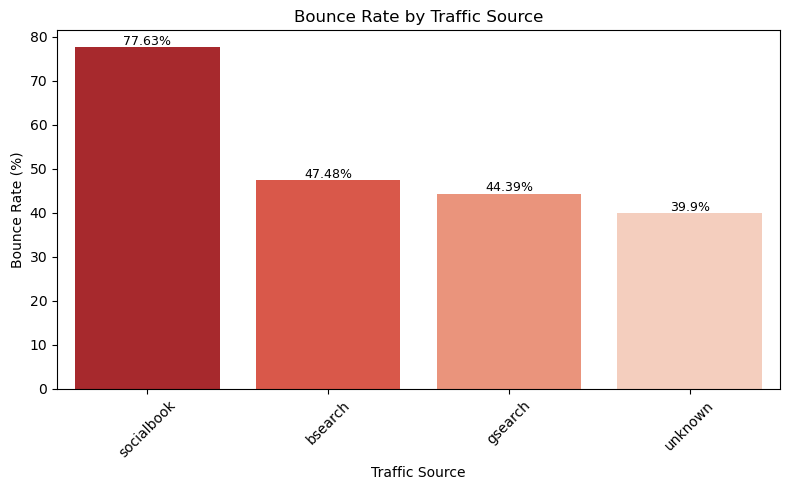

In [11]:
# Bounce Rate by Source

# STEP 1: Count pageviews per session
pageview_counts = (website_pageviews.groupby('website_session_id').size().reset_index(name='pageview_count'))

# STEP 2: Add bounce flag (only 1 pageview)
pageview_counts['is_bounce'] = pageview_counts['pageview_count'] == 1

# STEP 3: Merge with session data to get utm_source
session_data = w_sessions.merge(pageview_counts[['website_session_id', 'is_bounce']],on='website_session_id',how='left')

# Fill NaN (in case of sessions with no pageviews) as not bounced
session_data['is_bounce'] = session_data['is_bounce'].fillna(False)

# STEP 4: Group by utm_source and calculate bounce rate
bounce_by_source = (session_data.groupby('utm_source').agg(total_sessions=('website_session_id', 'nunique'),bounce_sessions=('is_bounce', 'sum'))
    .reset_index()
)

bounce_by_source['bounce_rate (%)'] = (
    bounce_by_source['bounce_sessions'] / bounce_by_source['total_sessions'] * 100
).round(2)

# Display result
print(bounce_by_source.sort_values(by='bounce_rate (%)', ascending=False))


# Sort data for better visualization
bounce_sorted = bounce_by_source.sort_values(by='bounce_rate (%)', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    data=bounce_sorted,
    x='utm_source',
    y='bounce_rate (%)',
    palette='Reds_r'
)

# Add data labels
for index, value in enumerate(bounce_sorted['bounce_rate (%)']):
    plt.text(index, value + 0.5, f'{value}%', ha='center', fontsize=9)

plt.title('Bounce Rate by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Bounce Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   utm_source  total_revenue  total_sessions  revenue_per_session
3     unknown   3.714330e+05           83328                 4.46
0     bsearch   2.686725e+05           62823                 4.28
1     gsearch   1.276145e+06          316035                 4.04
2  socialbook   2.225933e+04           10685                 2.08


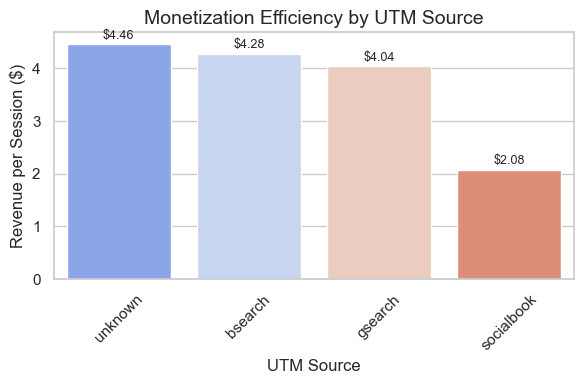

In [12]:
# Monetization Efficiency by Source

# STEP 1: Merge orders with sessions to attribute revenue to sources
orders_with_source = orders.merge(w_sessions[['website_session_id', 'utm_source']],on='website_session_id',how='left')

# STEP 2: Calculate total revenue per source
revenue_per_source = (orders_with_source.groupby('utm_source').agg(total_revenue=('price_usd', 'sum')).reset_index()
)

# STEP 3: Calculate total sessions per source
session_counts = (w_sessions.groupby('utm_source').agg(total_sessions=('website_session_id', 'nunique')).reset_index()
)

# STEP 4: Join revenue and sessions, compute monetization efficiency
monetization_efficiency = revenue_per_source.merge(session_counts,on='utm_source',how='outer')

monetization_efficiency['revenue_per_session'] = (monetization_efficiency['total_revenue'] / monetization_efficiency['total_sessions']).round(2)

# Fill NaN with 0 if some sources have no revenue/orders
monetization_efficiency.fillna({'total_revenue': 0, 'revenue_per_session': 0}, inplace=True)

# Sort for readability
monetization_efficiency = monetization_efficiency.sort_values(by='revenue_per_session', ascending=False)

print(monetization_efficiency)

# Set plot style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(6 ,4))
sns.barplot(
    data=monetization_efficiency,
    x='utm_source',
    y='revenue_per_session',
    palette='coolwarm'
)
#ADD DATA LABELS
for index, value in enumerate(monetization_efficiency['revenue_per_session']):
    plt.text(index, value + 0.1, f'${value:.2f}', ha='center', fontsize=9)

plt.title("Monetization Efficiency by UTM Source", fontsize=14)
plt.xlabel("UTM Source")
plt.ylabel("Revenue per Session ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Website Manager Analysis

In [ ]:
# WEBSITE MANAGER ANALYSIS
# 1. Top Entry Pages
entry_pages = website_pageviews.groupby('website_session_id').first().reset_index()
top_entry_pages = entry_pages['pageview_url'].value_counts().reset_index()
top_entry_pages.columns = ['pageview_url', 'entry_count']
top_entry_pages.head(10)

In [ ]:
# Top Pages Visited (Digital Diagnostic)

top_pages = website_pageviews['pageview_url'].value_counts().reset_index()
top_pages.columns = ['pageview_url', 'views']

plt.figure(figsize=(8, 4))
sns.barplot(data=top_pages.head(10), x='pageview_url', y='views', palette='viridis')
plt.title('Top 10 Visited Pages')
plt.xlabel('Page URL')
plt.ylabel('Page Views')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 2. Bounce Rate (single page sessions)
session_page_counts = website_pageviews[['website_session_id' ,'website_pageview_id']].groupby('website_session_id').count().reset_index()
bounce_sessions = session_page_counts[session_page_counts['website_pageview_id'] == 1]
bounce_rate = len(bounce_sessions) / len(session_page_counts) * 100
bounce_rate

In [ ]:
# 3. Conversion Rate
thank_you_sessions = website_pageviews[website_pageviews['pageview_url'] == '/thank-you-for-your-order']['website_session_id'].nunique()
total_sessions = w_sessions['website_session_id'].nunique()
conversion_rate = thank_you_sessions / total_sessions * 100
conversion_rate

In [ ]:
#4. Revenue per Session
# Total revenue
total_revenue = orders['price_usd'].sum()

# Total unique sessions (whether or not they made a purchase)
total_sessions = w_sessions['website_session_id'].nunique()

# Revenue per session (handle divide by zero)
revenue_per_session = total_revenue / total_sessions if total_sessions > 0 else 0

print(f"Revenue per session: ${revenue_per_session:.2f}")

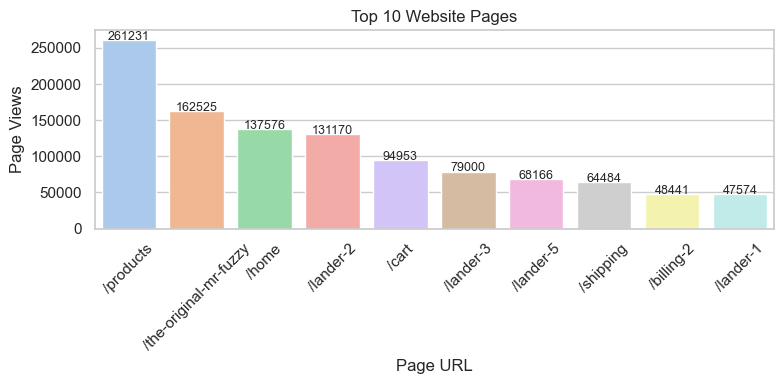

In [13]:
#5. Top Website Page
top_website_pages = website_pageviews['pageview_url'].value_counts().reset_index()
top_website_pages.columns = ['pageview_url', 'views']
top_website_pages.head(10)

#Visualizing the top website pages
plt.figure(figsize=(8, 4))
sns.barplot(data=top_website_pages.head(10), x='pageview_url', y='views', palette='pastel')
#ADD DATA LABELS
for index, value in enumerate(top_website_pages['views'].head(10)):
    plt.text(index, value + 50, f'{value}', ha='center', fontsize=9)
plt.title('Top 10 Website Pages')
plt.xlabel('Page URL')
plt.ylabel('Page Views')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


  landing_page  total_sessions  conversions  conversion_rate
5    /lander-5           68166         6930            10.17
2    /lander-2          131170        10128             7.72
4    /lander-4            9385          708             7.54
0        /home          137576         9711             7.06
1    /lander-1           47574         2157             4.53
3    /lander-3           79000         2679             3.39


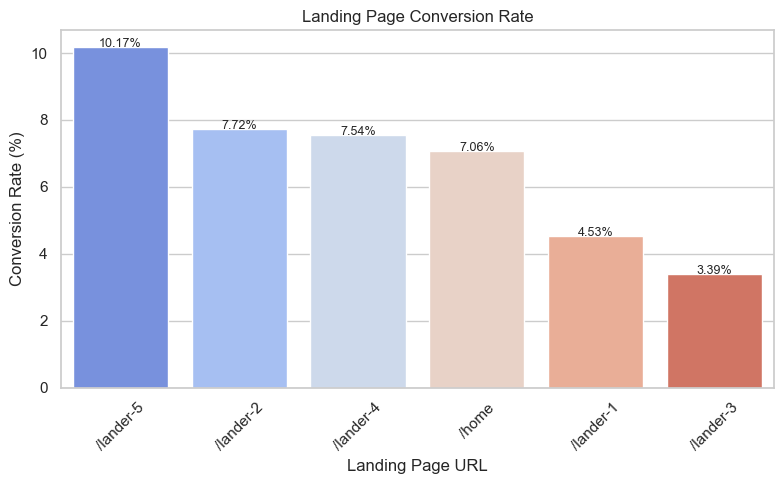

In [14]:
# Landing Page Conversion Rate Analysis

landing_pages = (
    website_pageviews
    .sort_values(by=['website_session_id', 'created_at'])  # Ensure correct order
    .groupby('website_session_id')                         # Group by session
    .first()                                               # First page = landing page
    .reset_index()[['website_session_id', 'pageview_url']] # Keep only relevant columns
    .rename(columns={'pageview_url': 'landing_page'})
)


landing_pages['converted'] = landing_pages['website_session_id'].isin(orders['website_session_id'])


landing_page_cvr = (
    landing_pages
    .groupby('landing_page')
    .agg(
        total_sessions=('website_session_id', 'nunique'),
        conversions=('converted', 'sum')
    )
    .reset_index()
)

landing_page_cvr['conversion_rate'] = (
    landing_page_cvr['conversions'] / landing_page_cvr['total_sessions']
)

landing_page_cvr['conversion_rate'] = (landing_page_cvr['conversion_rate'] * 100).round(2)
landing_page_cvr_sorted = landing_page_cvr.sort_values(by='conversion_rate', ascending=False)
print(landing_page_cvr.sort_values(by='conversion_rate', ascending=False))

#LANDING PAGE CONVERSION RATE VISUALIZATION
plt.figure(figsize=(8, 5))  
sns.barplot(
    data=landing_page_cvr_sorted,
    x='landing_page',
    y='conversion_rate',
    palette='coolwarm'
)

# Add data labels using the sorted data
for index, value in enumerate(landing_page_cvr_sorted['conversion_rate']):
    plt.text(index, value, f'{value}%', ha='center', fontsize=9)

plt.title('Landing Page Conversion Rate')
plt.xlabel('Landing Page URL')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Pageviews per session:
   website_session_id  pageview_count
0                   1               1
1                   2               1
2                   3               1
3                   4               1
4                   5               1

Page Depth Distribution:
pageview_count
1    211640
2     51017
3    115261
4     30469
5     12426
6     19745
7     32313
Name: count, dtype: int64


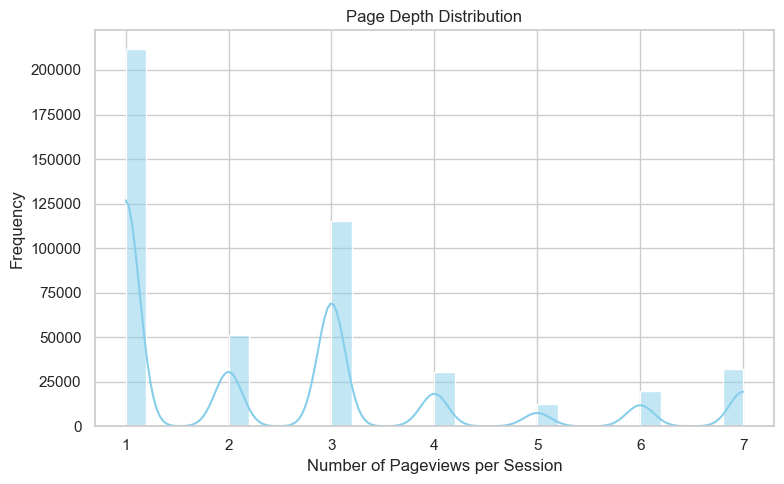

In [15]:
# Page Depth Analysis
# STEP 1: Count pageviews per session
page_depth = (
    website_pageviews
    .groupby('website_session_id')
    .size()
    .reset_index(name='pageview_count')
)

# STEP 2 (Optional): View distribution of page depth
depth_distribution = page_depth['pageview_count'].value_counts().sort_index()

print("Pageviews per session:")
print(page_depth.head())

print("\nPage Depth Distribution:")
print(depth_distribution)

#PAGE DEPTH VISUALIZATION
plt.figure(figsize=(8, 5))
sns.histplot(page_depth['pageview_count'], bins=30, kde=True, color='skyblue')
plt.title('Page Depth Distribution')
plt.xlabel('Number of Pageviews per Session')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Pageviews per session:
   website_session_id  pageview_count
0                   1               1
1                   2               1
2                   3               1
3                   4               1
4                   5               1

Page Depth Distribution:
   Pageviews per Session  Frequency
0                      1     211640
1                      2      51017
2                      3     115261
3                      4      30469
4                      5      12426
5                      6      19745
6                      7      32313


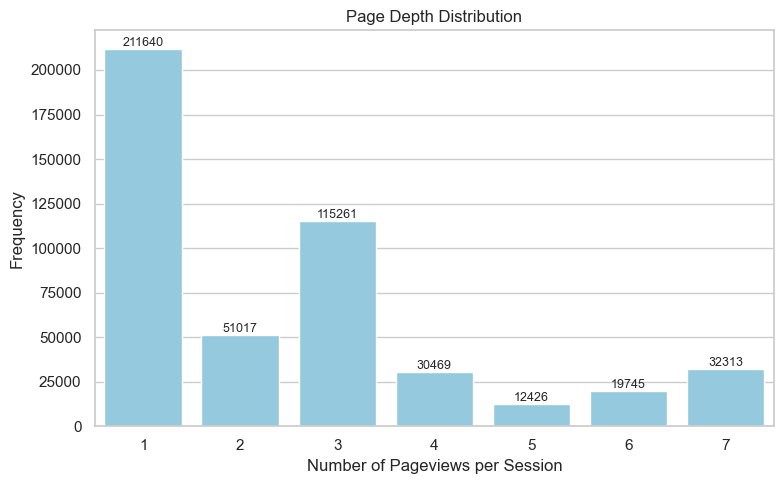

In [22]:
# Page Depth Analysis with Data Labels
# STEP 1: Count pageviews per session
page_depth = (
    website_pageviews
    .groupby('website_session_id')
    .size()
    .reset_index(name='pageview_count')
)

# STEP 2: Distribution of page depth
depth_distribution = page_depth['pageview_count'].value_counts().sort_index().reset_index()
depth_distribution.columns = ['Pageviews per Session', 'Frequency']

print("Pageviews per session:")
print(page_depth.head())

print("\nPage Depth Distribution:")
print(depth_distribution)

# PAGE DEPTH VISUALIZATION with data labels
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=depth_distribution, x='Pageviews per Session', y='Frequency', color='skyblue')

# Add data labels on each bar
for i, row in depth_distribution.iterrows():
    ax.text(i, row['Frequency'], str(int(row['Frequency'])), ha='center', va='bottom', fontsize=9)

plt.title('Page Depth Distribution')
plt.xlabel('Number of Pageviews per Session')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Number of multi-page sessions: 261231

Session Duration Statistics (Multi-page sessions only):
count    261231.000000
mean          7.160091
std           4.341877
min           0.330000
25%           4.070000
50%           6.170000
75%           9.350000
max          26.400000
Name: session_duration_min, dtype: float64

Session Counts by Duration (minutes):
    Session Duration (min)  Session Count
0                      0.0           1587
1                      1.0          11176
2                      2.0          16531
3                      3.0          21102
4                      4.0          27511
5                      5.0          32175
6                      6.0          28982
7                      7.0          23067
8                      8.0          20204
9                      9.0          15714
10                    10.0          11363
11                    11.0           8454
12                    12.0           8096
13                    13.0           7177
14       

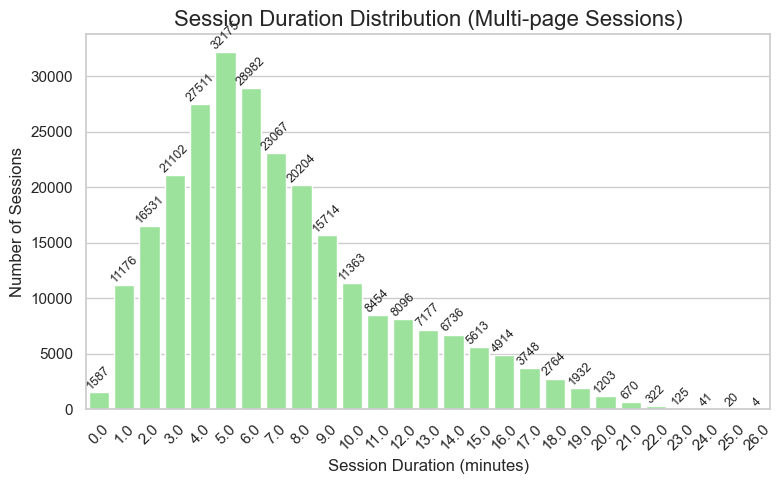

In [19]:
# SESSION DURATION ANALYSIS
# Ensure 'created_at_webpage' is in datetime format
website_pageviews['created_at_webpage'] = pd.to_datetime(website_pageviews['created_at'])

# Step 1: Identify session start and end timestamps
session_times = (
    website_pageviews.groupby('website_session_id')['created_at_webpage']
    .agg(session_start='min', session_end='max')
    .reset_index()
)

# Step 2: Calculate session duration in seconds and minutes
session_times['session_duration_sec'] = (session_times['session_end'] - session_times['session_start']).dt.total_seconds()
session_times['session_duration_min'] = (session_times['session_duration_sec'] / 60).round(2)
session_times['duration_rounded'] = session_times['session_duration_min'].round()

# Step 3: Filter sessions with more than 1 pageview (duration > 0 sec)
multi_page_sessions = session_times[session_times['session_duration_sec'] > 0]
print("Number of multi-page sessions:", len(multi_page_sessions))

print("\nSession Duration Statistics (Multi-page sessions only):")
print(multi_page_sessions['session_duration_min'].describe())

# Step 4: Count of sessions per rounded duration (minutes)
duration_counts = multi_page_sessions['duration_rounded'].value_counts().sort_index().reset_index()
duration_counts.columns = ['Session Duration (min)', 'Session Count']

print("\nSession Counts by Duration (minutes):")
print(duration_counts)

# Step 5: Plot bar chart (Session Duration Distribution)
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=duration_counts, x='Session Duration (min)', y='Session Count', color='lightgreen')

# Add count labels on bars
for i, row in duration_counts.iterrows():
    ax.text(i, row['Session Count'], str(int(row['Session Count'])), ha='center', rotation=45, va='bottom', fontsize=9)

ax.set_title('Session Duration Distribution (Multi-page Sessions)', fontsize=16)
ax.set_xlabel('Session Duration (minutes)', fontsize=12)
ax.set_ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
# Website Funnel Analysis

# STEP 1: Clean and standardize pageview URLs
website_pageviews['pageview_url'] = website_pageviews['pageview_url'].str.strip().str.lower()

# STEP 2: Create binary flags for each funnel step per session
funnel_flags = website_pageviews.pivot_table(
    index='website_session_id',
    columns='pageview_url',
    values='website_pageview_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# Rename known funnel steps (customize based on your URLs)
funnel_flags['visited_landing'] = (
    (funnel_flags.get('/home', 0) > 0) |
    (funnel_flags.get('/lander-1', 0) > 0) |
    (funnel_flags.get('/lander-2', 0) > 0) |
    (funnel_flags.get('/lander-3', 0) > 0) |
    (funnel_flags.get('/lander-4', 0) > 0) |
    (funnel_flags.get('/lander-5', 0) > 0)
)

funnel_flags['visited_product'] = (
    (funnel_flags.get('/products', 0) > 0) |
    (funnel_flags.get('/the-original-mr-fuzzy', 0) > 0) |
    (funnel_flags.get('/the-forever-love-bear', 0) > 0) |
    (funnel_flags.get('/the-birthday-sugar-panda', 0) > 0) |
    (funnel_flags.get('/the-hudson-river-mini-bear', 0) > 0)
)

funnel_flags['visited_cart'] = funnel_flags.get('/cart', 0) > 0
funnel_flags['visited_billing'] = (
    (funnel_flags.get('/billing', 0) > 0) |
    (funnel_flags.get('/billing-2', 0) > 0)
)
funnel_flags['visited_shipping'] = funnel_flags.get('/shipping', 0) > 0
funnel_flags['visited_order'] = funnel_flags.get('/thank-you-for-your-order', 0) > 0


# Everyone in this table is considered as having started a session (landing)
funnel_flags['visited_landing'] = True

# STEP 3: Count sessions at each step
funnel_counts = {
    'Landing': funnel_flags['visited_landing'].sum(),
    'Product': funnel_flags['visited_product'].sum(),
    'Cart': funnel_flags['visited_cart'].sum(),
    'Billing': funnel_flags['visited_billing'].sum(),
    'Shipping': funnel_flags['visited_shipping'].sum(),
    'Order': funnel_flags['visited_order'].sum()
}



# STEP 4: Create funnel DataFrame with drop-off and conversion rate
funnel_df = pd.DataFrame(list(funnel_counts.items()), columns=['Step', 'Sessions'])
funnel_df['Dropoff'] = funnel_df['Sessions'].shift(1) - funnel_df['Sessions']
funnel_df['Conversion_Rate (%)'] = (funnel_df['Sessions'] / funnel_df['Sessions'].shift(1) * 100).round(2)
funnel_df.fillna({'Dropoff': 0, 'Conversion_Rate (%)': 100}, inplace=True)

print(funnel_df)

# Display final funnel
print(funnel_df)


       Step  Sessions   Dropoff  Conversion_Rate (%)
0   Landing    472871       0.0               100.00
1   Product    261231  211640.0                55.24
2      Cart     94953  166278.0                36.35
3   Billing     52058   42895.0                54.83
4  Shipping     64484  -12426.0               123.87
5     Order     32313   32171.0                50.11
       Step  Sessions   Dropoff  Conversion_Rate (%)
0   Landing    472871       0.0               100.00
1   Product    261231  211640.0                55.24
2      Cart     94953  166278.0                36.35
3   Billing     52058   42895.0                54.83
4  Shipping     64484  -12426.0               123.87
5     Order     32313   32171.0                50.11


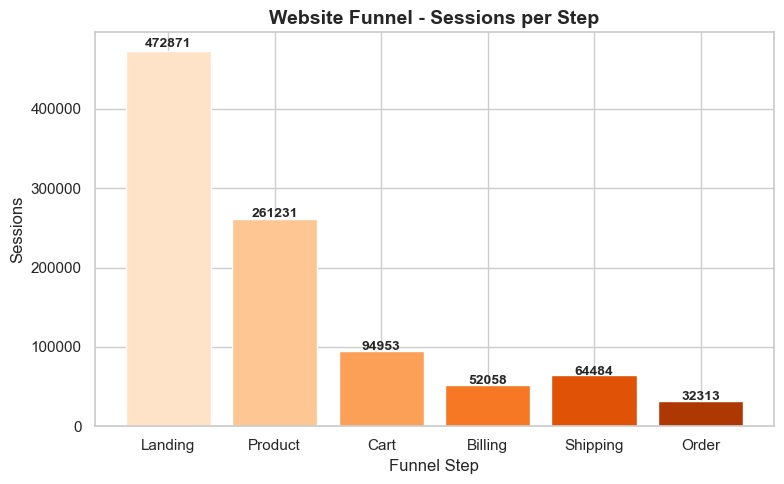

In [21]:
#website funnel visualization
plt.figure(figsize=(8,5))

# Correct color palette name: "Oranges"
colors = sns.color_palette("Oranges", n_colors=len(funnel_df['Step']))

plt.bar(funnel_df['Step'], funnel_df['Sessions'], color=colors)

for index, value in enumerate(funnel_df['Sessions']):
    plt.text(index, value + (0.01 * value), f'{int(value)}', ha='center', fontsize=10, fontweight='bold')

plt.title('Website Funnel - Sessions per Step', fontsize=14, fontweight='bold')
plt.xlabel('Funnel Step', fontsize=12)
plt.ylabel('Sessions', fontsize=12)
plt.tight_layout()
plt.show()
